# Lineal Regression a+b(x)
# Numpy and Pandas 

# 1. Trainind data set 
# 2. Validation data set
# 3. Test data set


In [23]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from sklearn import metrics 
dat = yf.Ticker("NVDA")
df = yf.download(["NVDA"], period='12mo', interval='1d') # Por hora o por minuto, o por dia 
df[('Prev Close', 'NVDA')] = df[('Close', 'NVDA')].shift(1)  # Shifted by 1 to use previous day's close to predict today's
df.dropna(inplace=True)  # Remove rows with NaN values
df.tail()
# df['Prev Close']

# dat.calendar
# dat.analyst_price_targets
# dat.quarterly_income_stmt
# dat.history(period='1mo')
# dat.option_chain(dat.options[0]).calls




[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Prev Close
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,,
2025-03-13,115.580002,117.760002,113.790001,117.029999,299033100,115.739998
2025-03-14,121.669998,121.879997,118.150002,118.610001,277593500,115.580002
2025-03-17,119.529999,122.889999,118.029999,122.739998,255501500,121.669998
2025-03-18,115.430000,119.019997,114.540001,118.000000,298384400,119.529999
2025-03-19,119.182404,119.260002,115.680000,117.305000,171626380,115.430000


In [24]:
x = df["Prev Close"]
y = df["Close"]

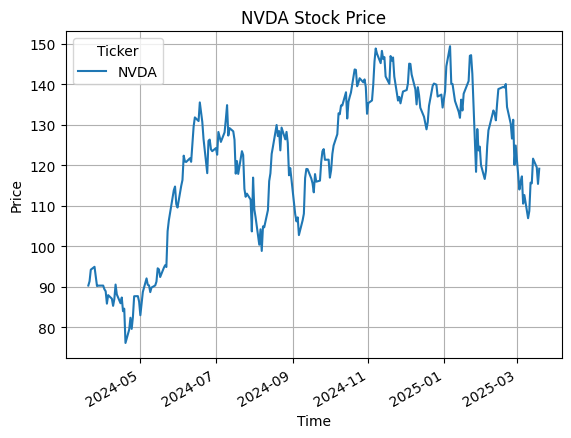

In [25]:
df["Close"].plot()
plt.title("NVDA Stock Price")
plt.ylabel("Price")
plt.xlabel("Time")
plt.grid(which="major")

In [26]:
def CreateTrainTestSet(x, y):
    features = x
    target = y

    data_len = x.shape[0]

    print("Historical data length: ", data_len)

    train_split = int(data_len * 0.88) # 88% training data
    print("Training data len: ", train_split)
    val_split = train_split + int(data_len * 0.1) # 10%
    print("Validation Set Len", val_split)
    X_train, X_val, X_test = features[:train_split], features[train_split:val_split], features[val_split:]
    Y_train, Y_val, Y_test = target[:train_split], target[train_split:val_split], target[val_split:]

    return X_train, X_val, X_test, Y_train, Y_val, Y_test


X_train, X_val, X_test, Y_train, Y_val, Y_test = CreateTrainTestSet(x, y)

Historical data length:  250
Training data len:  220
Validation Set Len 245


In [27]:
from sklearn.linear_model import LinearRegression

model = LinearRegression() 
model.fit(X_train, Y_train)

LinearRegression()

In [28]:
print("Performance (R^2):" , model.score(X_train, Y_train))

Performance (R^2): 0.9538051284924521


In [29]:
def get_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np. array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) *100

In [30]:
Y_train_pred = model.predict(X_train)
Y_val_pred = model.predict(X_val)
Y_test_pred = model.predict(X_test)


In [31]:
# print("Training R-squared: ",round(metrics.r2_score(Y_train,Y_train_pred),2))
# print("Training Explained Variation: ",round(metrics.explained_variance_score(Y_train,Y_train_pred),2))
# print('Training MAPE:', round(get_mape(Y_train,Y_train_pred), 2)) 
# print('Training Mean Squared Error:', round(metrics.mean_squared_error(Y_train,Y_train_pred), 2)) 
# print("Training RMSE: ",round(np.sqrt(metrics.mean_squared_error(Y_train,Y_train_pred)),2))
# print("Training MAE: ",round(metrics.mean_absolute_error(Y_train,Y_train_pred),2))

# print(' ')

# print("Validation R-squared: ",round(metrics.r2_score(Y_val,Y_val_pred),2))
# print("Validation Explained Variation: ",round(metrics.explained_variance_score(Y_val,Y_val_pred),2))
# print('Validation MAPE:', round(get_mape(Y_val,Y_val_pred), 2)) 
# print('Validation Mean Squared Error:', round(metrics.mean_squared_error(Y_train,Y_train_pred), 2)) 
# print("Validation RMSE: ",round(np.sqrt(metrics.mean_squared_error(Y_val,Y_val_pred)),2))
# print("Validation MAE: ",round(metrics.mean_absolute_error(Y_val,Y_val_pred),2))

# print(' ')

# print("Test R-squared: ",round(metrics.r2_score(Y_test,Y_test_pred),2))
# print("Test Explained Variation: ",round(metrics.explained_variance_score(Y_test,Y_test_pred),2))
# print('Test MAPE:', round(get_mape(Y_test,Y_test_pred), 2)) 
# print('Test Mean Squared Error:', round(metrics.mean_squared_error(Y_test,Y_test_pred), 2)) 
# print("Test RMSE: ",round(np.sqrt(metrics.mean_squared_error(Y_test,Y_test_pred)),2))
# print("Test MAE: ",round(metrics.mean_absolute_error(Y_test,Y_test_pred),2))

In [32]:
# df_pred = pd.DataFrame(Y_val.values, columns=['Actual'], index=Y_val.index)
# df_pred['Predicted'] = Y_val_pred
# df_pred = df_pred.reset_index()
# df_pred.loc[:, 'Date'] = pd.to_datetime(df_pred['Date'],format='%Y-%m-%d')
# df_pred

# Predicting tomorrows Stock Price

In [37]:
# Y_test.loc[-1] = Y_test.tail(1)
# df[('Prev Close', 'NVDA')] = df[('Close', 'NVDA')].shift(1)  # Shifted by 1 to use previous day's close to predict today's
# df.dropna(inplace=True)  # Remove rows with NaN values
# tomorrow['Date'] = pd.date_range('3/14/2025', periods = 1, freq ='D')
# tomorrow = pd.concat([Y_test, pd.DataFrame(
#     [{'Date': pd.Timestamp.today()}])]) # .reset_index(drop=True)
import datetime

tomorrow = Y_test.tail(1)
tomorrowsDate = datetime.date.today() + datetime.timedelta(days=1)
tomorrow.index = pd.MultiIndex.from_tuples([('NVDA', tomorrowsDate)], names=['Ticker', 'Date'])
tomorrowsPrice = model.predict(tomorrow)
df_pred = pd.DataFrame(tomorrow.values, columns=["Predicted"], index=tomorrow.index)
df_pred['Predicted'] = tomorrowsPrice
df_pred = df_pred.reset_index()
df_pred.loc[:, 'Date'] = pd.to_datetime(df_pred['Date'],format='%Y-%m-%d')
df_pred
print(tomorrow)


Ticker                   NVDA
Ticker Date                  
NVDA   2025-03-20  119.182404


> Get latest date 
# Agregar la fecha 
# Agregar 24 horas
- 2025-03-14

In [ ]:
# API Twitter X

# Selenium 

